In [1]:
from uncertainties import unumpy as unp
import numpy as np
from matplotlib import pyplot as plt

from pisa.core.distribution_maker import DistributionMaker
from pisa.analysis.analysis import Analysis
from pisa import ureg

<< PISA is running in double precision (FP64) mode; numba is running on CPU (single core) >>


Lets load two distribution makers: one with the "clasical" MultiDimBinning (test) and one with the variable binning (test_var). The test_var uses different energy and coszen binnings for different PID bins.

In [2]:
test = DistributionMaker('resources/settings/pipeline/fast_example.cfg')
test_var = DistributionMaker('resources/settings/pipeline/varbin_example.cfg')

[ WARNING] /data/user/jweldert/miniconda3/envs/pisa/lib/python3.9/site-packages/pint/quantity.py:221: BehaviorChangeWarning: The way Pint handles NumPy operations has changed with the
implementation of NEP 18. Unimplemented NumPy operations will now fail instead of making
assumptions about units. Some functions, eg concat, will now return Quanties with units, where
they returned ndarrays previously. See https://github.com/hgrecco/pint/pull/905.

To hide this warning, wrap your first creation of an array Quantity with
warnings.catch_warnings(), like the following:

import numpy as np
import warnings
from pint import Quantity

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    Quantity([])

To disable the new behavior, see
https://www.numpy.org/neps/nep-0018-array-function-protocol.html#implementation

  warnings.warn(array_function_change_msg, BehaviorChangeWarning)

[ WARNING] renaming the outdated "oppo" flux keys in "nue_cc", in the future do not use those anymor

Getting the output of the distribution maker works in the same way for both. The difference is that "out" will be a MapSet, while "out_var" will be a list of MapSets.

In [3]:
%%time
out = test.get_outputs(return_sum=True)

CPU times: user 305 ms, sys: 15.6 ms, total: 320 ms
Wall time: 319 ms


In [4]:
%%time
out_var = test_var.get_outputs(return_sum=True)

CPU times: user 92.4 ms, sys: 1.04 ms, total: 93.5 ms
Wall time: 92.4 ms


For the first PID bin the outputs should be identical. 

In [5]:
a = unp.nominal_values(out['total'].hist[:,:,0])
b = unp.nominal_values(out_var[0]['total'].hist)
np.all(np.isclose(a, b))

True

In [6]:
a = unp.std_devs(out['total'].hist[:,:,0])
b = unp.std_devs(out_var[0]['total'].hist)
np.all(np.isclose(a, b))

True

For the second PID bin, since we use twice as many coszen bins for "out_var", we have to add up every two bins in the coszen dim to get the same binning as for "out".

In [7]:
a = unp.nominal_values(out['total'].hist)[:,:,1]
b = unp.nominal_values(out_var[1]['total'].hist[:,1::2]+out_var[1]['total'].hist[:,0::2])
np.all(np.isclose(a, b))

True

In [8]:
a = unp.std_devs(out['total'].hist)[:,:,1]
b = unp.std_devs(out_var[1]['total'].hist[:,1::2]+out_var[1]['total'].hist[:,0::2])
np.all(np.isclose(a, b))

True

Check if an Asimov fit that is not startet at the truth, returns to it.

In [9]:
ana = Analysis()

In [10]:
# local minimizer
local_fit_minuit = {
    "method": "iminuit",
    "method_kwargs": {
        "errors": 0.1,
        "precision": 1e-14,  # default: double precision
        "tol": 1e-2,  # default: 0.1
        "run_simplex": False,
        "run_migrad": True
    },
    "local_fit_kwargs": None
}

# octant fit for local minimizer
fit_octant = {
    "method": "octants",
    "method_kwargs": {
        "angle": "theta23",
        "inflection_point": 45 * ureg.degrees,
    },
    "local_fit_kwargs": local_fit_minuit
}

In [11]:
test.params['aeff_scale'] = 0.9
test_var.params['aeff_scale'] = 0.9

In [12]:
%%time
result = ana.fit_recursively(
    data_dist=out,
    hypo_maker=test,
    metric="mod_chi2",
    external_priors_penalty=None,
    **fit_octant
)

                                                 (deg)                 
 iter   funcalls    mod_chi2   | delta_index    theta23     aeff_scale 
------ ---------- ------------ + ------------ ------------ ------------
  0        0       4.84685e+00 |  0.00000e+00  4.23000e+01  9.00000e-01
  0        1       4.86333e+00 |  1.00679e-03  4.23000e+01  9.00000e-01
  0        2       4.83135e+00 | -1.00679e-03  4.23000e+01  9.00000e-01
  0        3       4.84845e+00 |  1.00679e-04  4.23000e+01  9.00000e-01
  0        4       4.84525e+00 | -1.00679e-04  4.23000e+01  9.00000e-01
  0        5       4.85210e+00 |  0.00000e+00  4.23436e+01  9.00000e-01
  0        6       4.84234e+00 |  0.00000e+00  4.22560e+01  9.00000e-01
  0        7       4.84740e+00 |  0.00000e+00  4.23049e+01  9.00000e-01
  0        8       4.84631e+00 |  0.00000e+00  4.22951e+01  9.00000e-01
  0        9       4.52603e+00 |  0.00000e+00  4.23000e+01  9.03041e-01
  0        10      5.18060e+00 |  0.00000e+00  4.23000e+01  8.96

In [13]:
%%time
result_var = ana.fit_recursively(
    data_dist=out_var,
    hypo_maker=test_var,
    metric="mod_chi2",
    external_priors_penalty=None,
    **fit_octant
)

                                                 (deg)                 
 iter   funcalls    mod_chi2   | delta_index    theta23     aeff_scale 
------ ---------- ------------ + ------------ ------------ ------------
  0        0       5.13950e+00 |  0.00000e+00  4.23000e+01  9.00000e-01
  0        1       5.15597e+00 |  1.00679e-03  4.23000e+01  9.00000e-01
  0        2       5.12407e+00 | -1.00679e-03  4.23000e+01  9.00000e-01
  0        3       5.14110e+00 |  1.00679e-04  4.23000e+01  9.00000e-01
  0        4       5.13791e+00 | -1.00679e-04  4.23000e+01  9.00000e-01
  0        5       5.15366e+00 |  0.00000e+00  4.23436e+01  9.00000e-01
  0        6       5.12773e+00 |  0.00000e+00  4.22560e+01  9.00000e-01
  0        7       5.14081e+00 |  0.00000e+00  4.23044e+01  9.00000e-01
  0        8       5.13822e+00 |  0.00000e+00  4.22956e+01  9.00000e-01
  0        9       4.79933e+00 |  0.00000e+00  4.23000e+01  9.03041e-01
  0        10      5.49340e+00 |  0.00000e+00  4.23000e+01  8.96



CPU times: user 11.7 s, sys: 34.2 ms, total: 11.8 s
Wall time: 11.7 s


Fit an peseudo experiment ensemble and check if we fit the true parameter values on average (except for aeff which will be biased to higher values because of the chi2 metric)

In [39]:
results = []
for i in range(100):
    PE = [d.fluctuate(method="poisson", random_state=i) for d in out_var]
    
    result_var = ana.fit_recursively(
        data_dist=PE,
        hypo_maker=test_var,
        metric="mod_chi2",
        external_priors_penalty=None,
        **fit_octant
    )
    
    results.append(result_var.params.free)

                                                 (deg)                 
 iter   funcalls    mod_chi2   | delta_index    theta23     aeff_scale 
------ ---------- ------------ + ------------ ------------ ------------
  0        0       2.99029e+01 |  1.65858e-01  4.23000e+01  1.32144e+00
  0        1       2.99656e+01 |  1.66869e-01  4.23000e+01  1.32144e+00
  0        2       2.98408e+01 |  1.64847e-01  4.23000e+01  1.32144e+00
  0        3       2.99216e+01 |  1.66161e-01  4.23000e+01  1.32144e+00
  0        4       2.98843e+01 |  1.65556e-01  4.23000e+01  1.32144e+00
  0        5       2.98870e+01 |  1.65858e-01  4.23436e+01  1.32144e+00
  0        6       2.99199e+01 |  1.65858e-01  4.22560e+01  1.32144e+00
  0        7       2.98994e+01 |  1.65858e-01  4.23093e+01  1.32144e+00
  0        8       2.99065e+01 |  1.65858e-01  4.22906e+01  1.32144e+00
  0        9       3.02055e+01 |  1.65858e-01  4.23000e+01  1.32447e+00
  0        10      2.96018e+01 |  1.65858e-01  4.23000e+01  1.31

  0        43      2.45014e+00 | -1.87546e-03  4.81787e+01  9.98397e-01
  0        44      2.45013e+00 | -1.85871e-03  4.81787e+01  9.98478e-01
  0        45      2.45013e+00 | -1.89220e-03  4.81787e+01  9.98478e-01
  0        46      2.45013e+00 | -1.87546e-03  4.81793e+01  9.98478e-01
  0        47      2.45013e+00 | -1.87546e-03  4.81782e+01  9.98478e-01
  0        48      2.45013e+00 | -1.87546e-03  4.81787e+01  9.98495e-01
  0        49      2.45013e+00 | -1.87546e-03  4.81787e+01  9.98462e-01
  0        50      2.45014e+00 | -1.79173e-03  4.81815e+01  9.98478e-01
  0        51      2.45014e+00 | -1.79173e-03  4.81787e+01  9.98560e-01
  0        52      2.45014e+00 | -1.87546e-03  4.81815e+01  9.98560e-01


                                                 (deg)                 
 iter   funcalls    mod_chi2   | delta_index    theta23     aeff_scale 
------ ---------- ------------ + ------------ ------------ ------------
  0        0       2.09163e+00 | -3.77632e-03  4.23000e+01  9.

  0        45      2.05559e+00 |  3.60513e-03  4.88210e+01  9.99094e-01
  0        46      2.05559e+00 |  3.60513e-03  4.88210e+01  9.98941e-01
  0        47      2.05559e+00 |  3.60513e-03  4.88210e+01  9.99017e-01
  0        48      2.05559e+00 |  3.68382e-03  4.88210e+01  9.99017e-01
  0        49      2.05559e+00 |  3.52643e-03  4.88210e+01  9.99017e-01
  0        50      2.05559e+00 |  3.60513e-03  4.88239e+01  9.99017e-01
  0        51      2.05559e+00 |  3.60513e-03  4.88182e+01  9.99017e-01
  0        52      2.05559e+00 |  3.60513e-03  4.88210e+01  9.99094e-01
  0        53      2.05559e+00 |  3.60513e-03  4.88210e+01  9.98941e-01
  0        54      2.05559e+00 |  3.62086e-03  4.88210e+01  9.99017e-01
  0        55      2.05559e+00 |  3.58939e-03  4.88210e+01  9.99017e-01
  0        56      2.05559e+00 |  3.60513e-03  4.88216e+01  9.99017e-01
  0        57      2.05559e+00 |  3.60513e-03  4.88205e+01  9.99017e-01
  0        58      2.05559e+00 |  3.60513e-03  4.88211e+01  9.99

  0        36      4.32045e+00 |  1.28838e-02  4.82666e+01  1.01684e+00
  0        37      4.32045e+00 |  1.29876e-02  4.82666e+01  1.01684e+00
  0        38      4.32045e+00 |  1.27801e-02  4.82666e+01  1.01684e+00
  0        39      4.32045e+00 |  1.28838e-02  4.82699e+01  1.01684e+00
  0        40      4.32045e+00 |  1.28838e-02  4.82633e+01  1.01684e+00
  0        41      4.32046e+00 |  1.28838e-02  4.82666e+01  1.01694e+00
  0        42      4.32045e+00 |  1.28838e-02  4.82666e+01  1.01673e+00
  0        43      4.32045e+00 |  1.29046e-02  4.82666e+01  1.01684e+00
  0        44      4.32045e+00 |  1.28631e-02  4.82666e+01  1.01684e+00
  0        45      4.32045e+00 |  1.28880e-02  4.82666e+01  1.01684e+00
  0        46      4.32045e+00 |  1.28797e-02  4.82666e+01  1.01684e+00
  0        47      4.32045e+00 |  1.28838e-02  4.82673e+01  1.01684e+00
  0        48      4.32045e+00 |  1.28838e-02  4.82660e+01  1.01684e+00
  0        49      4.32045e+00 |  1.28838e-02  4.82666e+01  1.01

  0        45      2.58863e+00 |  2.08845e-03  4.81127e+01  1.00227e+00
  0        46      2.58863e+00 |  2.08845e-03  4.81133e+01  1.00229e+00
  0        47      2.58863e+00 |  2.08845e-03  4.81133e+01  1.00225e+00
  0        48      2.58864e+00 |  2.17387e-03  4.81164e+01  1.00227e+00
  0        49      2.58864e+00 |  2.17387e-03  4.81133e+01  1.00235e+00
  0        50      2.58864e+00 |  2.08845e-03  4.81164e+01  1.00235e+00


                                                 (deg)                 
 iter   funcalls    mod_chi2   | delta_index    theta23     aeff_scale 
------ ---------- ------------ + ------------ ------------ ------------
  0        0       1.10791e+01 |  1.33538e-04  4.23000e+01  1.00317e+00
  0        1       1.10962e+01 |  1.14033e-03  4.23000e+01  1.00317e+00
  0        2       1.10629e+01 | -8.73252e-04  4.23000e+01  1.00317e+00
  0        3       1.10817e+01 |  2.87654e-04  4.23000e+01  1.00317e+00
  0        4       1.10766e+01 | -2.05787e-05  4.23000e+01  1.

  0        9       1.96913e+00 | -1.89301e-02  4.23000e+01  1.01995e+00
  0        10      1.85858e+00 | -1.89301e-02  4.23000e+01  1.01389e+00
  0        11      1.91604e+00 | -1.89301e-02  4.23000e+01  1.01722e+00
  0        12      1.90498e+00 | -1.89301e-02  4.23000e+01  1.01662e+00
  0        13      1.60441e+00 | -4.07423e-04  4.27467e+01  9.92199e-01
  0        14      1.57505e+00 | -4.30973e-03  4.26558e+01  9.97393e-01
  0        15      1.57506e+00 | -4.23465e-03  4.26558e+01  9.97393e-01
  0        16      1.57504e+00 | -4.38482e-03  4.26558e+01  9.97393e-01
  0        17      1.57520e+00 | -4.30973e-03  4.26582e+01  9.97393e-01
  0        18      1.57490e+00 | -4.30973e-03  4.26534e+01  9.97393e-01
  0        19      1.57510e+00 | -4.30973e-03  4.26558e+01  9.97468e-01
  0        20      1.57500e+00 | -4.30973e-03  4.26558e+01  9.97319e-01
  0        21      1.57314e+00 | -4.26975e-03  4.25720e+01  9.96278e-01
  0        22      1.57288e+00 | -4.28015e-03  4.25939e+01  9.96

  0        19      1.83440e+00 | -2.37837e-03  4.15555e+01  1.00102e+00
  0        20      1.83468e+00 | -2.37837e-03  4.15573e+01  1.00110e+00
  0        21      1.83425e+00 | -2.37837e-03  4.15573e+01  1.00095e+00
  0        22      1.82725e+00 | -4.94646e-04  4.15111e+01  9.97522e-01
  0        23      1.82729e+00 | -4.18978e-04  4.15111e+01  9.97522e-01
  0        24      1.82721e+00 | -5.70315e-04  4.15111e+01  9.97522e-01
  0        25      1.82728e+00 | -4.94646e-04  4.15135e+01  9.97522e-01
  0        26      1.82722e+00 | -4.94646e-04  4.15087e+01  9.97522e-01
  0        27      1.82725e+00 | -4.94646e-04  4.15111e+01  9.97596e-01
  0        28      1.82725e+00 | -4.94646e-04  4.15111e+01  9.97448e-01
  0        29      1.82704e+00 | -9.83736e-04  4.15013e+01  9.97470e-01
  0        30      1.82703e+00 | -1.10923e-03  4.14988e+01  9.97457e-01
  0        31      1.82703e+00 | -1.03397e-03  4.14988e+01  9.97457e-01
  0        32      1.82704e+00 | -1.18449e-03  4.14988e+01  9.97

  0        10      2.51731e+00 | -1.10923e-03  4.23000e+01  9.94425e-01
  0        11      2.49785e+00 | -1.10923e-03  4.23000e+01  9.97760e-01
  0        12      2.50068e+00 | -1.10923e-03  4.23000e+01  9.97153e-01
  0        13      2.48184e+00 |  1.17595e-03  4.23321e+01  1.00295e+00
  0        14      2.48153e+00 |  1.51273e-03  4.23369e+01  1.00376e+00
  0        15      2.48149e+00 |  1.59621e-03  4.23369e+01  1.00376e+00
  0        16      2.48157e+00 |  1.42925e-03  4.23369e+01  1.00376e+00
  0        17      2.48152e+00 |  1.51273e-03  4.23392e+01  1.00376e+00
  0        18      2.48154e+00 |  1.51273e-03  4.23345e+01  1.00376e+00
  0        19      2.48154e+00 |  1.51273e-03  4.23369e+01  1.00384e+00
  0        20      2.48151e+00 |  1.51273e-03  4.23369e+01  1.00368e+00
  0        21      2.48137e+00 |  2.13765e-03  4.23427e+01  1.00360e+00
  0        22      2.48137e+00 |  2.06441e-03  4.23421e+01  1.00362e+00
  0        23      2.48137e+00 |  2.14832e-03  4.23421e+01  1.00

  0        20      2.44633e+00 | -4.90991e-04  4.23704e+01  9.99594e-01
  0        21      2.44633e+00 | -4.07754e-04  4.23704e+01  9.99594e-01
  0        22      2.44634e+00 | -5.74228e-04  4.23704e+01  9.99594e-01
  0        23      2.44633e+00 | -4.90991e-04  4.23727e+01  9.99594e-01
  0        24      2.44633e+00 | -4.90991e-04  4.23681e+01  9.99594e-01
  0        25      2.44634e+00 | -4.90991e-04  4.23704e+01  9.99676e-01
  0        26      2.44633e+00 | -4.90991e-04  4.23704e+01  9.99513e-01
  0        27      2.44633e+00 | -4.90991e-04  4.23704e+01  9.99594e-01
  0        28      2.44633e+00 | -4.07754e-04  4.23704e+01  9.99594e-01
  0        29      2.44634e+00 | -5.74228e-04  4.23704e+01  9.99594e-01
  0        30      2.44633e+00 | -4.90991e-04  4.23727e+01  9.99594e-01
  0        31      2.44633e+00 | -4.90991e-04  4.23681e+01  9.99594e-01
  0        32      2.44634e+00 | -4.90991e-04  4.23704e+01  9.99676e-01
  0        33      2.44633e+00 | -4.90991e-04  4.23704e+01  9.99

  0        39      1.90279e+00 |  6.32824e-03  4.25514e+01  1.01266e+00
  0        40      1.90279e+00 |  6.40449e-03  4.25536e+01  1.01266e+00
  0        41      1.90279e+00 |  6.40449e-03  4.25491e+01  1.01266e+00
  0        42      1.90279e+00 |  6.40449e-03  4.25514e+01  1.01273e+00
  0        43      1.90279e+00 |  6.40449e-03  4.25514e+01  1.01258e+00
  0        44      1.90279e+00 |  6.41974e-03  4.25514e+01  1.01266e+00
  0        45      1.90279e+00 |  6.38924e-03  4.25514e+01  1.01266e+00
  0        46      1.90279e+00 |  6.40449e-03  4.25518e+01  1.01266e+00
  0        47      1.90279e+00 |  6.40449e-03  4.25509e+01  1.01266e+00
  0        48      1.90279e+00 |  6.40449e-03  4.25514e+01  1.01267e+00
  0        49      1.90279e+00 |  6.40449e-03  4.25514e+01  1.01264e+00
  0        50      1.90279e+00 |  6.48074e-03  4.25536e+01  1.01266e+00
  0        51      1.90279e+00 |  6.48074e-03  4.25514e+01  1.01273e+00
  0        52      1.90279e+00 |  6.40449e-03  4.25536e+01  1.01

  0        50      1.09162e+01 | -2.24109e-02  4.20111e+01  1.00799e+00
  0        51      1.09162e+01 | -2.25678e-02  4.20157e+01  1.00799e+00


                                                 (deg)                 
 iter   funcalls    mod_chi2   | delta_index    theta23     aeff_scale 
------ ---------- ------------ + ------------ ------------ ------------
  0        0       1.18552e+01 |  0.00000e+00  4.77000e+01  1.00000e+00
  0        1       1.18749e+01 |  1.00679e-03  4.77000e+01  1.00000e+00
  0        2       1.18362e+01 | -1.00679e-03  4.77000e+01  1.00000e+00
  0        3       1.18106e+01 |  0.00000e+00  4.77440e+01  1.00000e+00
  0        4       1.19030e+01 |  0.00000e+00  4.76564e+01  1.00000e+00
  0        5       1.18506e+01 |  0.00000e+00  4.77044e+01  1.00000e+00
  0        6       1.18598e+01 |  0.00000e+00  4.76956e+01  1.00000e+00
  0        7       1.18234e+01 |  0.00000e+00  4.77000e+01  1.00303e+00
  0        8       1.18948e+01 |  0.00000e+00  4.77000e+01  9.

  0        51      2.36430e+00 | -9.69961e-04  4.27769e+01  1.00605e+00
  0        52      2.36430e+00 | -1.05225e-03  4.27793e+01  1.00605e+00


                                                 (deg)                 
 iter   funcalls    mod_chi2   | delta_index    theta23     aeff_scale 
------ ---------- ------------ + ------------ ------------ ------------
  0        0       2.80741e+00 |  0.00000e+00  4.77000e+01  1.00000e+00
  0        1       2.80858e+00 |  1.00679e-03  4.77000e+01  1.00000e+00
  0        2       2.80706e+00 | -1.00679e-03  4.77000e+01  1.00000e+00
  0        3       2.80749e+00 |  1.00679e-04  4.77000e+01  1.00000e+00
  0        4       2.80734e+00 | -1.00679e-04  4.77000e+01  1.00000e+00
  0        5       2.80559e+00 |  0.00000e+00  4.77440e+01  1.00000e+00
  0        6       2.81042e+00 |  0.00000e+00  4.76564e+01  1.00000e+00
  0        7       2.80718e+00 |  0.00000e+00  4.77044e+01  1.00000e+00
  0        8       2.80766e+00 |  0.00000e+00  4.76956e+01  1.

  0        13      3.34331e+00 |  4.24687e-03  4.82503e+01  1.01192e+00
  0        14      3.33549e+00 |  4.63555e-03  4.83030e+01  1.01301e+00
  0        15      3.33116e+00 |  5.09739e-03  4.83661e+01  1.01431e+00
  0        16      3.33088e+00 |  5.19007e-03  4.83661e+01  1.01431e+00
  0        17      3.33144e+00 |  5.00470e-03  4.83661e+01  1.01431e+00
  0        18      3.33099e+00 |  5.09739e-03  4.83681e+01  1.01431e+00
  0        19      3.33133e+00 |  5.09739e-03  4.83641e+01  1.01431e+00
  0        20      3.33151e+00 |  5.09739e-03  4.83661e+01  1.01440e+00
  0        21      3.33082e+00 |  5.09739e-03  4.83661e+01  1.01422e+00
  0        22      3.31205e+00 |  9.15052e-03  4.84477e+01  1.01031e+00
  0        23      3.31185e+00 |  9.62487e-03  4.84574e+01  1.00984e+00
  0        24      3.31193e+00 |  9.71877e-03  4.84574e+01  1.00984e+00
  0        25      3.31177e+00 |  9.53097e-03  4.84574e+01  1.00984e+00
  0        26      3.31175e+00 |  9.62487e-03  4.84603e+01  1.00

  0        17      1.08478e+01 | -1.73726e-02  4.79745e+01  1.01469e+00
  0        18      1.08479e+01 | -1.73726e-02  4.79664e+01  1.01469e+00
  0        19      1.08479e+01 | -1.73726e-02  4.79705e+01  1.01484e+00
  0        20      1.08478e+01 | -1.73726e-02  4.79705e+01  1.01455e+00
  0        21      1.08476e+01 | -1.80243e-02  4.79778e+01  1.01441e+00
  0        22      1.08475e+01 | -1.81567e-02  4.79793e+01  1.01436e+00
  0        23      1.08476e+01 | -1.79995e-02  4.79793e+01  1.01436e+00
  0        24      1.08476e+01 | -1.83138e-02  4.79793e+01  1.01436e+00
  0        25      1.08476e+01 | -1.81567e-02  4.79841e+01  1.01436e+00
  0        26      1.08476e+01 | -1.81567e-02  4.79746e+01  1.01436e+00
  0        27      1.08476e+01 | -1.81567e-02  4.79793e+01  1.01451e+00
  0        28      1.08476e+01 | -1.81567e-02  4.79793e+01  1.01420e+00
  0        29      1.08475e+01 | -1.81567e-02  4.79793e+01  1.01436e+00
  0        30      1.08476e+01 | -1.79995e-02  4.79793e+01  1.01

  0        28      2.04904e+00 |  3.69947e-03  4.80381e+01  1.00028e+00
  0        29      2.04904e+00 |  3.69947e-03  4.80381e+01  1.00035e+00
  0        30      2.04905e+00 |  3.77828e-03  4.80381e+01  1.00035e+00
  0        31      2.04904e+00 |  3.62067e-03  4.80381e+01  1.00035e+00
  0        32      2.04903e+00 |  3.69947e-03  4.80412e+01  1.00035e+00
  0        33      2.04905e+00 |  3.69947e-03  4.80350e+01  1.00035e+00
  0        34      2.04904e+00 |  3.69947e-03  4.80381e+01  1.00043e+00
  0        35      2.04904e+00 |  3.69947e-03  4.80381e+01  1.00028e+00
  0        36      2.04904e+00 |  3.71523e-03  4.80381e+01  1.00035e+00
  0        37      2.04904e+00 |  3.68371e-03  4.80381e+01  1.00035e+00
  0        38      2.04904e+00 |  3.69947e-03  4.80387e+01  1.00035e+00
  0        39      2.04904e+00 |  3.69947e-03  4.80375e+01  1.00035e+00
  0        40      2.04904e+00 |  3.69947e-03  4.80381e+01  1.00037e+00
  0        41      2.04904e+00 |  3.69947e-03  4.80381e+01  1.00

  0        46      3.06168e+00 |  2.56335e-03  4.83628e+01  9.95925e-01
  0        47      3.06168e+00 |  2.58150e-03  4.83634e+01  9.95925e-01
  0        48      3.06168e+00 |  2.58150e-03  4.83621e+01  9.95925e-01
  0        49      3.06168e+00 |  2.58150e-03  4.83628e+01  9.95942e-01
  0        50      3.06168e+00 |  2.58150e-03  4.83628e+01  9.95907e-01
  0        51      3.06168e+00 |  2.67226e-03  4.83660e+01  9.95925e-01
  0        52      3.06168e+00 |  2.67226e-03  4.83628e+01  9.96013e-01
  0        53      3.06168e+00 |  2.58150e-03  4.83660e+01  9.96013e-01


                                                 (deg)                 
 iter   funcalls    mod_chi2   | delta_index    theta23     aeff_scale 
------ ---------- ------------ + ------------ ------------ ------------
  0        0       1.25605e+01 |  4.21898e-04  4.23000e+01  9.96784e-01
  0        1       1.25721e+01 |  1.42869e-03  4.23000e+01  9.96784e-01
  0        2       1.25497e+01 | -5.84891e-04  4.23000e+01  9.

  0        1       2.54095e+00 | -9.09631e-03  4.23000e+01  1.01944e+00
  0        2       2.56025e+00 | -1.11099e-02  4.23000e+01  1.01944e+00
  0        3       2.54926e+00 | -1.00025e-02  4.23000e+01  1.01944e+00
  0        4       2.55119e+00 | -1.02038e-02  4.23000e+01  1.01944e+00
  0        5       2.58431e+00 | -1.01031e-02  4.23436e+01  1.01944e+00
  0        6       2.51940e+00 | -1.01031e-02  4.22560e+01  1.01944e+00
  0        7       2.55348e+00 | -1.01031e-02  4.23044e+01  1.01944e+00
  0        8       2.54699e+00 | -1.01031e-02  4.22956e+01  1.01944e+00
  0        9       2.60189e+00 | -1.01031e-02  4.23000e+01  1.02248e+00
  0        10      2.50535e+00 | -1.01031e-02  4.23000e+01  1.01641e+00
  0        11      2.55508e+00 | -1.01031e-02  4.23000e+01  1.01975e+00
  0        12      2.54543e+00 | -1.01031e-02  4.23000e+01  1.01914e+00
  0        13      2.13438e+00 |  2.76174e-03  4.18486e+01  9.97958e-01
  0        14      2.13320e+00 |  3.50162e-03  4.18217e+01  9.96

  0        59      2.19836e+00 |  3.18089e-03  4.88604e+01  9.96322e-01
  0        60      2.19836e+00 |  3.18089e-03  4.88604e+01  9.96291e-01
  0        61      2.19837e+00 |  3.26157e-03  4.88632e+01  9.96306e-01
  0        62      2.19837e+00 |  3.26157e-03  4.88604e+01  9.96385e-01
  0        63      2.19837e+00 |  3.18089e-03  4.88632e+01  9.96385e-01


                                                 (deg)                 
 iter   funcalls    mod_chi2   | delta_index    theta23     aeff_scale 
------ ---------- ------------ + ------------ ------------ ------------
  0        0       2.55489e+00 |  3.57370e-04  4.23000e+01  9.98004e-01
  0        1       2.55621e+00 |  1.36416e-03  4.23000e+01  9.98004e-01
  0        2       2.55439e+00 | -6.49420e-04  4.23000e+01  9.98004e-01
  0        3       2.55499e+00 |  4.58049e-04  4.23000e+01  9.98004e-01
  0        4       2.55481e+00 |  2.56691e-04  4.23000e+01  9.98004e-01
  0        5       2.56510e+00 |  3.57370e-04  4.23436e+01  9.

  0        3       1.23491e+00 |  8.30765e-07  4.23000e+01  1.00004e+00
  0        4       1.23487e+00 | -2.00527e-04  4.23000e+01  1.00004e+00
  0        5       1.22589e+00 | -9.98482e-05  4.23436e+01  1.00004e+00
  0        6       1.24511e+00 | -9.98482e-05  4.22560e+01  1.00004e+00
  0        7       1.23393e+00 | -9.98482e-05  4.23044e+01  1.00004e+00
  0        8       1.23586e+00 | -9.98482e-05  4.22956e+01  1.00004e+00
  0        9       1.24960e+00 | -9.98482e-05  4.23000e+01  1.00307e+00
  0        10      1.22770e+00 | -9.98482e-05  4.23000e+01  9.97009e-01
  0        11      1.23602e+00 | -9.98482e-05  4.23000e+01  1.00034e+00
  0        12      1.23383e+00 | -9.98482e-05  4.23000e+01  9.99737e-01
  0        13      1.19610e+00 | -3.75953e-04  4.26355e+01  9.95625e-01
  0        14      1.19462e+00 | -3.38482e-04  4.25912e+01  9.96224e-01
  0        15      1.19468e+00 | -2.71547e-04  4.25912e+01  9.96224e-01
  0        16      1.19457e+00 | -4.05416e-04  4.25912e+01  9.96

  0        23      2.93624e+00 | -2.79970e-03  4.18225e+01  1.00425e+00
  0        24      2.93627e+00 | -2.70973e-03  4.18251e+01  1.00425e+00
  0        25      2.93623e+00 | -2.70973e-03  4.18198e+01  1.00425e+00
  0        26      2.93625e+00 | -2.70973e-03  4.18225e+01  1.00434e+00
  0        27      2.93625e+00 | -2.70973e-03  4.18225e+01  1.00416e+00
  0        28      2.93619e+00 | -2.90793e-03  4.18152e+01  1.00421e+00
  0        29      2.93619e+00 | -2.96038e-03  4.18133e+01  1.00420e+00
  0        30      2.93619e+00 | -2.87073e-03  4.18133e+01  1.00420e+00
  0        31      2.93619e+00 | -3.05002e-03  4.18133e+01  1.00420e+00
  0        32      2.93619e+00 | -2.96038e-03  4.18160e+01  1.00420e+00
  0        33      2.93619e+00 | -2.96038e-03  4.18106e+01  1.00420e+00
  0        34      2.93619e+00 | -2.96038e-03  4.18133e+01  1.00428e+00
  0        35      2.93619e+00 | -2.96038e-03  4.18133e+01  1.00411e+00
  0        36      2.93619e+00 | -2.96038e-03  4.18133e+01  1.00

  0        25      2.57581e+00 |  1.78425e-03  4.22702e+01  1.00467e+00
  0        26      2.57581e+00 |  1.78425e-03  4.22656e+01  1.00467e+00
  0        27      2.57581e+00 |  1.78425e-03  4.22679e+01  1.00475e+00
  0        28      2.57581e+00 |  1.78425e-03  4.22679e+01  1.00459e+00
  0        29      2.57581e+00 |  1.78425e-03  4.22679e+01  1.00467e+00
  0        30      2.57581e+00 |  1.86922e-03  4.22679e+01  1.00467e+00
  0        31      2.57581e+00 |  1.69927e-03  4.22679e+01  1.00467e+00
  0        32      2.57581e+00 |  1.78425e-03  4.22702e+01  1.00467e+00
  0        33      2.57581e+00 |  1.78425e-03  4.22656e+01  1.00467e+00
  0        34      2.57581e+00 |  1.78425e-03  4.22679e+01  1.00475e+00
  0        35      2.57581e+00 |  1.78425e-03  4.22679e+01  1.00459e+00
  0        36      2.57581e+00 |  1.80124e-03  4.22679e+01  1.00467e+00
  0        37      2.57581e+00 |  1.76725e-03  4.22679e+01  1.00467e+00
  0        38      2.57581e+00 |  1.78425e-03  4.22683e+01  1.00

  0        35      1.35016e+01 |  2.18276e-02  4.23288e+01  1.02107e+00
  0        36      1.35016e+01 |  2.18617e-02  4.23288e+01  1.02124e+00
  0        37      1.35016e+01 |  2.17935e-02  4.23288e+01  1.02124e+00
  0        38      1.35016e+01 |  2.18276e-02  4.23297e+01  1.02124e+00
  0        39      1.35016e+01 |  2.18276e-02  4.23279e+01  1.02124e+00
  0        40      1.35016e+01 |  2.18276e-02  4.23288e+01  1.02128e+00
  0        41      1.35016e+01 |  2.18276e-02  4.23288e+01  1.02121e+00
  0        42      1.35016e+01 |  2.19983e-02  4.23333e+01  1.02124e+00
  0        43      1.35016e+01 |  2.19983e-02  4.23288e+01  1.02142e+00
  0        44      1.35016e+01 |  2.18276e-02  4.23333e+01  1.02142e+00


                                                 (deg)                 
 iter   funcalls    mod_chi2   | delta_index    theta23     aeff_scale 
------ ---------- ------------ + ------------ ------------ ------------
  0        0       1.43387e+01 |  0.00000e+00  4.77000e+01  1.

  0        46      1.58633e+02 |  1.68085e-01  4.36914e+01  1.33198e+00
  0        47      1.58633e+02 |  1.68736e-01  4.36914e+01  1.33198e+00
  0        48      1.58633e+02 |  1.67433e-01  4.36914e+01  1.33198e+00
  0        49      1.58633e+02 |  1.68085e-01  4.37031e+01  1.33198e+00
  0        50      1.58633e+02 |  1.68085e-01  4.36797e+01  1.33198e+00
  0        51      1.58633e+02 |  1.68085e-01  4.36914e+01  1.33291e+00
  0        52      1.58633e+02 |  1.68085e-01  4.36914e+01  1.33105e+00
  0        53      1.58633e+02 |  1.67995e-01  4.36941e+01  1.33217e+00
  0        54      1.58633e+02 |  1.67954e-01  4.36953e+01  1.33226e+00
  0        55      1.58633e+02 |  1.68607e-01  4.36953e+01  1.33226e+00
  0        56      1.58633e+02 |  1.67302e-01  4.36953e+01  1.33226e+00
  0        57      1.58633e+02 |  1.67954e-01  4.37069e+01  1.33226e+00
  0        58      1.58633e+02 |  1.67954e-01  4.36836e+01  1.33226e+00
  0        59      1.58633e+02 |  1.67954e-01  4.36953e+01  1.33

  0        80      1.59101e+02 |  1.67968e-01  4.65550e+01  1.33584e+00


                                                 (deg)                 
 iter   funcalls    mod_chi2   | delta_index    theta23     aeff_scale 
------ ---------- ------------ + ------------ ------------ ------------
  0        0       3.04865e+01 |  1.67954e-01  4.23000e+01  1.33226e+00
  0        1       3.05464e+01 |  1.68965e-01  4.23000e+01  1.33226e+00
  0        2       3.04272e+01 |  1.66943e-01  4.23000e+01  1.33226e+00
  0        3       3.05048e+01 |  1.68263e-01  4.23000e+01  1.33226e+00
  0        4       3.04684e+01 |  1.67646e-01  4.23000e+01  1.33226e+00
  0        5       3.04710e+01 |  1.67954e-01  4.23436e+01  1.33226e+00
  0        6       3.05031e+01 |  1.67954e-01  4.22560e+01  1.33226e+00
  0        7       3.04830e+01 |  1.67954e-01  4.23097e+01  1.33226e+00
  0        8       3.04901e+01 |  1.67954e-01  4.22903e+01  1.33226e+00
  0        9       3.07959e+01 |  1.67954e-01  4.23000e+01  1.

  0        34      2.30341e+00 |  5.49053e-03  4.82123e+01  1.00025e+00
  0        35      2.30342e+00 |  5.49053e-03  4.82066e+01  1.00025e+00
  0        36      2.30341e+00 |  5.49053e-03  4.82095e+01  1.00033e+00
  0        37      2.30342e+00 |  5.49053e-03  4.82095e+01  1.00017e+00
  0        38      2.30341e+00 |  5.49053e-03  4.82095e+01  1.00025e+00
  0        39      2.30341e+00 |  5.57213e-03  4.82095e+01  1.00025e+00
  0        40      2.30342e+00 |  5.40894e-03  4.82095e+01  1.00025e+00
  0        41      2.30341e+00 |  5.49053e-03  4.82123e+01  1.00025e+00
  0        42      2.30342e+00 |  5.49053e-03  4.82066e+01  1.00025e+00
  0        43      2.30341e+00 |  5.49053e-03  4.82095e+01  1.00033e+00
  0        44      2.30342e+00 |  5.49053e-03  4.82095e+01  1.00017e+00
  0        45      2.30341e+00 |  5.50685e-03  4.82095e+01  1.00025e+00
  0        46      2.30341e+00 |  5.47422e-03  4.82095e+01  1.00025e+00
  0        47      2.30341e+00 |  5.49053e-03  4.82100e+01  1.00

  0        34      2.62869e+00 |  1.58509e-03  4.87702e+01  1.00115e+00
  0        35      2.62870e+00 |  1.58509e-03  4.87634e+01  1.00115e+00
  0        36      2.62869e+00 |  1.58509e-03  4.87668e+01  1.00124e+00
  0        37      2.62870e+00 |  1.58509e-03  4.87668e+01  1.00107e+00
  0        38      2.62869e+00 |  1.58509e-03  4.87668e+01  1.00115e+00
  0        39      2.62869e+00 |  1.67129e-03  4.87668e+01  1.00115e+00
  0        40      2.62870e+00 |  1.49888e-03  4.87668e+01  1.00115e+00
  0        41      2.62869e+00 |  1.58509e-03  4.87702e+01  1.00115e+00
  0        42      2.62870e+00 |  1.58509e-03  4.87634e+01  1.00115e+00
  0        43      2.62869e+00 |  1.58509e-03  4.87668e+01  1.00124e+00
  0        44      2.62870e+00 |  1.58509e-03  4.87668e+01  1.00107e+00
  0        45      2.62869e+00 |  1.60233e-03  4.87668e+01  1.00115e+00
  0        46      2.62869e+00 |  1.56784e-03  4.87668e+01  1.00115e+00
  0        47      2.62869e+00 |  1.58509e-03  4.87675e+01  1.00

  0        44      2.05335e+00 |  5.43492e-03  4.82979e+01  9.98235e-01
  0        45      2.05335e+00 |  5.43492e-03  4.83006e+01  9.98311e-01
  0        46      2.05335e+00 |  5.43492e-03  4.83006e+01  9.98158e-01
  0        47      2.05335e+00 |  5.45058e-03  4.83006e+01  9.98235e-01
  0        48      2.05335e+00 |  5.41926e-03  4.83006e+01  9.98235e-01
  0        49      2.05335e+00 |  5.43492e-03  4.83011e+01  9.98235e-01
  0        50      2.05335e+00 |  5.43492e-03  4.83000e+01  9.98235e-01
  0        51      2.05335e+00 |  5.43492e-03  4.83006e+01  9.98250e-01
  0        52      2.05335e+00 |  5.43492e-03  4.83006e+01  9.98219e-01
  0        53      2.05335e+00 |  5.51321e-03  4.83032e+01  9.98235e-01
  0        54      2.05335e+00 |  5.51321e-03  4.83006e+01  9.98311e-01
  0        55      2.05335e+00 |  5.43492e-03  4.83032e+01  9.98311e-01


                                                 (deg)                 
 iter   funcalls    mod_chi2   | delta_index    theta23     ae

  0        51      4.03931e+00 |  1.11200e-02  4.83913e+01  1.00648e+00
  0        52      4.03931e+00 |  1.11200e-02  4.83878e+01  1.00658e+00
  0        53      4.03931e+00 |  1.10194e-02  4.83913e+01  1.00658e+00


                                                 (deg)                 
 iter   funcalls    mod_chi2   | delta_index    theta23     aeff_scale 
------ ---------- ------------ + ------------ ------------ ------------
  0        0       8.53811e+00 |  9.06404e-03  4.23000e+01  1.00739e+00
  0        1       8.54205e+00 |  1.00708e-02  4.23000e+01  1.00739e+00
  0        2       8.53499e+00 |  8.05722e-03  4.23000e+01  1.00739e+00
  0        3       8.53861e+00 |  9.20203e-03  4.23000e+01  1.00739e+00
  0        4       8.53764e+00 |  8.92605e-03  4.23000e+01  1.00739e+00
  0        5       8.53864e+00 |  9.06404e-03  4.23436e+01  1.00739e+00
  0        6       8.53975e+00 |  9.06404e-03  4.22560e+01  1.00739e+00
  0        7       8.53807e+00 |  9.06404e-03  4.23044e+01  1.

  0        6       3.02412e+00 |  6.06993e-03  4.22560e+01  1.01747e+00
  0        7       3.06405e+00 |  6.06993e-03  4.23044e+01  1.01747e+00
  0        8       3.05650e+00 |  6.06993e-03  4.22956e+01  1.01747e+00
  0        9       3.08966e+00 |  6.06993e-03  4.23000e+01  1.02050e+00
  0        10      3.03791e+00 |  6.06993e-03  4.23000e+01  1.01444e+00
  0        11      3.06288e+00 |  6.06993e-03  4.23000e+01  1.01777e+00
  0        12      3.05771e+00 |  6.06993e-03  4.23000e+01  1.01716e+00
  0        13      2.71013e+00 | -3.02111e-03  4.17683e+01  1.00635e+00
  0        14      2.69325e+00 | -4.91212e-03  4.16522e+01  1.00405e+00
  0        15      2.69134e+00 | -5.62307e-03  4.16081e+01  1.00318e+00
  0        16      2.69125e+00 | -5.53522e-03  4.16081e+01  1.00318e+00
  0        17      2.69144e+00 | -5.71093e-03  4.16081e+01  1.00318e+00
  0        18      2.69137e+00 | -5.62307e-03  4.16101e+01  1.00318e+00
  0        19      2.69131e+00 | -5.62307e-03  4.16060e+01  1.00

  0        63      2.80341e+00 | -1.52249e-03  4.89384e+01  1.00048e+00


                                                 (deg)                 
 iter   funcalls    mod_chi2   | delta_index    theta23     aeff_scale 
------ ---------- ------------ + ------------ ------------ ------------
  0        0       1.66031e+00 | -4.37992e-03  4.23000e+01  1.00208e+00
  0        1       1.65531e+00 | -3.37312e-03  4.23000e+01  1.00208e+00
  0        2       1.66610e+00 | -5.38670e-03  4.23000e+01  1.00208e+00
  0        3       1.65977e+00 | -4.27924e-03  4.23000e+01  1.00208e+00
  0        4       1.66085e+00 | -4.48060e-03  4.23000e+01  1.00208e+00
  0        5       1.69487e+00 | -4.37992e-03  4.23436e+01  1.00208e+00
  0        6       1.62900e+00 | -4.37992e-03  4.22560e+01  1.00208e+00
  0        7       1.66361e+00 | -4.37992e-03  4.23044e+01  1.00208e+00
  0        8       1.65703e+00 | -4.37992e-03  4.22956e+01  1.00208e+00
  0        9       1.65402e+00 | -4.37992e-03  4.23000e+01  1.

  0        54      1.53509e+00 |  6.45782e-03  4.87595e+01  1.00342e+00
  0        55      1.53509e+00 |  6.47214e-03  4.87595e+01  1.00349e+00
  0        56      1.53509e+00 |  6.44351e-03  4.87595e+01  1.00349e+00
  0        57      1.53509e+00 |  6.45782e-03  4.87600e+01  1.00349e+00
  0        58      1.53509e+00 |  6.45782e-03  4.87591e+01  1.00349e+00
  0        59      1.53509e+00 |  6.45782e-03  4.87595e+01  1.00350e+00
  0        60      1.53509e+00 |  6.45782e-03  4.87595e+01  1.00347e+00
  0        61      1.53509e+00 |  6.52938e-03  4.87619e+01  1.00349e+00
  0        62      1.53509e+00 |  6.52938e-03  4.87595e+01  1.00356e+00
  0        63      1.53509e+00 |  6.45782e-03  4.87619e+01  1.00356e+00


                                                 (deg)                 
 iter   funcalls    mod_chi2   | delta_index    theta23     aeff_scale 
------ ---------- ------------ + ------------ ------------ ------------
  0        0       2.75344e+00 |  3.89536e-03  4.23000e+01  1.

  0        44      2.85169e+00 |  1.05793e-02  4.88043e+01  1.00320e+00
  0        45      2.85169e+00 |  1.05442e-02  4.88043e+01  1.00320e+00
  0        46      2.85169e+00 |  1.05618e-02  4.88050e+01  1.00320e+00
  0        47      2.85169e+00 |  1.05618e-02  4.88037e+01  1.00320e+00
  0        48      2.85169e+00 |  1.05618e-02  4.88043e+01  1.00322e+00
  0        49      2.85169e+00 |  1.05618e-02  4.88043e+01  1.00319e+00
  0        50      2.85168e+00 |  1.06496e-02  4.88077e+01  1.00320e+00
  0        51      2.85169e+00 |  1.06496e-02  4.88043e+01  1.00329e+00
  0        52      2.85168e+00 |  1.05618e-02  4.88077e+01  1.00329e+00


                                                 (deg)                 
 iter   funcalls    mod_chi2   | delta_index    theta23     aeff_scale 
------ ---------- ------------ + ------------ ------------ ------------
  0        0       3.21079e+00 |  8.09083e-03  4.23000e+01  1.00475e+00
  0        1       3.21036e+00 |  9.09761e-03  4.23000e+01  1.

  0        0       2.21103e+00 |  9.73973e-03  4.23000e+01  1.01069e+00
  0        1       2.21173e+00 |  1.07465e-02  4.23000e+01  1.01069e+00
  0        2       2.21114e+00 |  8.73292e-03  4.23000e+01  1.01069e+00
  0        3       2.21106e+00 |  9.84041e-03  4.23000e+01  1.01069e+00
  0        4       2.21100e+00 |  9.63905e-03  4.23000e+01  1.01069e+00
  0        5       2.22125e+00 |  9.73973e-03  4.23436e+01  1.01069e+00
  0        6       2.20327e+00 |  9.73973e-03  4.22560e+01  1.01069e+00
  0        7       2.21194e+00 |  9.73973e-03  4.23044e+01  1.01069e+00
  0        8       2.21014e+00 |  9.73973e-03  4.22956e+01  1.01069e+00
  0        9       2.21342e+00 |  9.73973e-03  4.23000e+01  1.01372e+00
  0        10      2.21613e+00 |  9.73973e-03  4.23000e+01  1.00766e+00
  0        11      2.21093e+00 |  9.73973e-03  4.23000e+01  1.01099e+00
  0        12      2.21120e+00 |  9.73973e-03  4.23000e+01  1.01039e+00
  0        13      2.19407e+00 |  9.37113e-03  4.21385e+01  1.01

  0        10      1.84609e+00 |  9.75788e-03  4.23000e+01  1.00762e+00
  0        11      1.87949e+00 |  9.75788e-03  4.23000e+01  1.01096e+00
  0        12      1.87277e+00 |  9.75788e-03  4.23000e+01  1.01035e+00
  0        13      1.72354e+00 |  2.04327e-03  4.27133e+01  9.96363e-01
  0        14      1.72372e+00 |  2.11838e-03  4.27133e+01  9.96363e-01
  0        15      1.72336e+00 |  1.96815e-03  4.27133e+01  9.96363e-01
  0        16      1.72379e+00 |  2.04327e-03  4.27158e+01  9.96363e-01
  0        17      1.72330e+00 |  2.04327e-03  4.27108e+01  9.96363e-01
  0        18      1.72352e+00 |  2.04327e-03  4.27133e+01  9.96438e-01
  0        19      1.72356e+00 |  2.04327e-03  4.27133e+01  9.96288e-01
  0        20      1.71597e+00 | -1.02977e-03  4.26080e+01  9.96001e-01
  0        21      1.71587e+00 | -6.83592e-04  4.26200e+01  9.96042e-01
  0        22      1.71588e+00 | -6.09404e-04  4.26200e+01  9.96042e-01
  0        23      1.71586e+00 | -7.57779e-04  4.26200e+01  9.96

  0        21      1.58633e+00 |  2.81542e-03  4.23228e+01  1.00091e+00
  0        22      1.58633e+00 |  2.77652e-03  4.23220e+01  1.00093e+00
  0        23      1.58633e+00 |  2.84835e-03  4.23220e+01  1.00093e+00
  0        24      1.58633e+00 |  2.70468e-03  4.23220e+01  1.00093e+00
  0        25      1.58633e+00 |  2.77652e-03  4.23241e+01  1.00093e+00
  0        26      1.58633e+00 |  2.77652e-03  4.23200e+01  1.00093e+00
  0        27      1.58633e+00 |  2.77652e-03  4.23220e+01  1.00100e+00
  0        28      1.58633e+00 |  2.77652e-03  4.23220e+01  1.00086e+00
  0        29      1.58633e+00 |  2.77652e-03  4.23220e+01  1.00093e+00
  0        30      1.58633e+00 |  2.84835e-03  4.23220e+01  1.00093e+00
  0        31      1.58633e+00 |  2.70468e-03  4.23220e+01  1.00093e+00
  0        32      1.58633e+00 |  2.77652e-03  4.23241e+01  1.00093e+00
  0        33      1.58633e+00 |  2.77652e-03  4.23200e+01  1.00093e+00
  0        34      1.58633e+00 |  2.77652e-03  4.23220e+01  1.00

  0        30      3.16702e+01 |  5.60416e-02  4.24153e+01  1.06093e+00
  0        31      3.16702e+01 |  5.62972e-02  4.24153e+01  1.06093e+00
  0        32      3.16702e+01 |  5.57860e-02  4.24153e+01  1.06093e+00
  0        33      3.16702e+01 |  5.60416e-02  4.24216e+01  1.06093e+00
  0        34      3.16702e+01 |  5.60416e-02  4.24089e+01  1.06093e+00
  0        35      3.16702e+01 |  5.60416e-02  4.24153e+01  1.06121e+00
  0        36      3.16702e+01 |  5.60416e-02  4.24153e+01  1.06065e+00
  0        37      3.16702e+01 |  5.60416e-02  4.24153e+01  1.06093e+00
  0        38      3.16702e+01 |  5.62972e-02  4.24153e+01  1.06093e+00
  0        39      3.16702e+01 |  5.57860e-02  4.24153e+01  1.06093e+00
  0        40      3.16702e+01 |  5.60416e-02  4.24216e+01  1.06093e+00
  0        41      3.16702e+01 |  5.60416e-02  4.24089e+01  1.06093e+00
  0        42      3.16702e+01 |  5.60416e-02  4.24153e+01  1.06121e+00
  0        43      3.16702e+01 |  5.60416e-02  4.24153e+01  1.06

  0        27      2.01618e+00 |  2.55410e-03  4.22051e+01  1.00613e+00
  0        28      2.01619e+00 |  2.55410e-03  4.22073e+01  1.00620e+00
  0        29      2.01618e+00 |  2.55410e-03  4.22073e+01  1.00605e+00
  0        30      2.01617e+00 |  2.50364e-03  4.22033e+01  1.00602e+00
  0        31      2.01617e+00 |  2.58110e-03  4.22033e+01  1.00602e+00
  0        32      2.01617e+00 |  2.42618e-03  4.22033e+01  1.00602e+00
  0        33      2.01617e+00 |  2.50364e-03  4.22055e+01  1.00602e+00
  0        34      2.01617e+00 |  2.50364e-03  4.22010e+01  1.00602e+00
  0        35      2.01617e+00 |  2.50364e-03  4.22033e+01  1.00609e+00
  0        36      2.01617e+00 |  2.50364e-03  4.22033e+01  1.00594e+00
  0        37      2.01617e+00 |  2.50364e-03  4.22033e+01  1.00602e+00
  0        38      2.01617e+00 |  2.58110e-03  4.22033e+01  1.00602e+00
  0        39      2.01617e+00 |  2.42618e-03  4.22033e+01  1.00602e+00
  0        40      2.01617e+00 |  2.50364e-03  4.22055e+01  1.00

  0        28      2.36283e+00 | -4.31705e-03  4.24380e+01  9.98367e-01
  0        29      2.36283e+00 | -4.31705e-03  4.24380e+01  9.98447e-01
  0        30      2.36283e+00 | -4.23457e-03  4.24380e+01  9.98447e-01
  0        31      2.36284e+00 | -4.39952e-03  4.24380e+01  9.98447e-01
  0        32      2.36284e+00 | -4.31705e-03  4.24402e+01  9.98447e-01
  0        33      2.36283e+00 | -4.31705e-03  4.24358e+01  9.98447e-01
  0        34      2.36284e+00 | -4.31705e-03  4.24380e+01  9.98527e-01
  0        35      2.36283e+00 | -4.31705e-03  4.24380e+01  9.98367e-01
  0        36      2.36283e+00 | -4.30055e-03  4.24380e+01  9.98447e-01
  0        37      2.36283e+00 | -4.33354e-03  4.24380e+01  9.98447e-01
  0        38      2.36283e+00 | -4.31705e-03  4.24384e+01  9.98447e-01
  0        39      2.36283e+00 | -4.31705e-03  4.24375e+01  9.98447e-01
  0        40      2.36283e+00 | -4.31705e-03  4.24380e+01  9.98463e-01
  0        41      2.36283e+00 | -4.31705e-03  4.24380e+01  9.98

  0        45      2.25720e+00 | -1.57045e-03  4.15740e+01  9.94950e-01
  0        46      2.25720e+00 | -1.60293e-03  4.15740e+01  9.94950e-01
  0        47      2.25720e+00 | -1.58669e-03  4.15745e+01  9.94950e-01
  0        48      2.25720e+00 | -1.58669e-03  4.15736e+01  9.94950e-01
  0        49      2.25720e+00 | -1.58669e-03  4.15740e+01  9.94966e-01
  0        50      2.25720e+00 | -1.58669e-03  4.15740e+01  9.94934e-01
  0        51      2.25720e+00 | -1.50548e-03  4.15764e+01  9.94950e-01
  0        52      2.25720e+00 | -1.50548e-03  4.15740e+01  9.95029e-01
  0        53      2.25720e+00 | -1.58669e-03  4.15764e+01  9.95029e-01


                                                 (deg)                 
 iter   funcalls    mod_chi2   | delta_index    theta23     aeff_scale 
------ ---------- ------------ + ------------ ------------ ------------
  0        0       3.44903e+00 |  0.00000e+00  4.77000e+01  1.00000e+00
  0        1       3.45161e+00 |  1.00679e-03  4.77000e+01  1.

  0        34      1.89597e+00 |  3.65706e-03  4.15921e+01  1.00078e+00
  0        35      1.89597e+00 |  3.65706e-03  4.15946e+01  1.00085e+00
  0        36      1.89597e+00 |  3.65706e-03  4.15946e+01  1.00070e+00
  0        37      1.89597e+00 |  3.65706e-03  4.15946e+01  1.00078e+00
  0        38      1.89597e+00 |  3.73310e-03  4.15946e+01  1.00078e+00
  0        39      1.89597e+00 |  3.58102e-03  4.15946e+01  1.00078e+00
  0        40      1.89597e+00 |  3.65706e-03  4.15971e+01  1.00078e+00
  0        41      1.89597e+00 |  3.65706e-03  4.15921e+01  1.00078e+00
  0        42      1.89597e+00 |  3.65706e-03  4.15946e+01  1.00085e+00
  0        43      1.89597e+00 |  3.65706e-03  4.15946e+01  1.00070e+00
  0        44      1.89597e+00 |  3.67227e-03  4.15946e+01  1.00078e+00
  0        45      1.89597e+00 |  3.64185e-03  4.15946e+01  1.00078e+00
  0        46      1.89597e+00 |  3.65706e-03  4.15951e+01  1.00078e+00
  0        47      1.89597e+00 |  3.65706e-03  4.15941e+01  1.00

  0        26      2.42379e+00 |  6.76054e-03  4.30333e+01  1.00960e+00
  0        27      2.42383e+00 |  6.76054e-03  4.30288e+01  1.00960e+00
  0        28      2.42380e+00 |  6.76054e-03  4.30311e+01  1.00968e+00
  0        29      2.42382e+00 |  6.76054e-03  4.30311e+01  1.00951e+00
  0        30      2.42362e+00 |  7.39541e-03  4.30417e+01  1.00983e+00
  0        31      2.42362e+00 |  7.33873e-03  4.30407e+01  1.00981e+00
  0        32      2.42362e+00 |  7.42131e-03  4.30407e+01  1.00981e+00
  0        33      2.42362e+00 |  7.25616e-03  4.30407e+01  1.00981e+00
  0        34      2.42362e+00 |  7.33873e-03  4.30430e+01  1.00981e+00
  0        35      2.42362e+00 |  7.33873e-03  4.30384e+01  1.00981e+00
  0        36      2.42362e+00 |  7.33873e-03  4.30407e+01  1.00989e+00
  0        37      2.42362e+00 |  7.33873e-03  4.30407e+01  1.00973e+00
  0        38      2.42362e+00 |  7.33873e-03  4.30407e+01  1.00981e+00
  0        39      2.42362e+00 |  7.42131e-03  4.30407e+01  1.00

  0        29      3.15634e+01 |  4.72206e-02  4.26101e+01  1.05224e+00
  0        30      3.15634e+01 |  4.74757e-02  4.26101e+01  1.05224e+00
  0        31      3.15634e+01 |  4.69655e-02  4.26101e+01  1.05224e+00
  0        32      3.15634e+01 |  4.72206e-02  4.26162e+01  1.05224e+00
  0        33      3.15634e+01 |  4.72206e-02  4.26041e+01  1.05224e+00
  0        34      3.15634e+01 |  4.72206e-02  4.26101e+01  1.05251e+00
  0        35      3.15634e+01 |  4.72206e-02  4.26101e+01  1.05197e+00
  0        36      3.15634e+01 |  4.72206e-02  4.26101e+01  1.05224e+00
  0        37      3.15634e+01 |  4.74757e-02  4.26101e+01  1.05224e+00
  0        38      3.15634e+01 |  4.69655e-02  4.26101e+01  1.05224e+00
  0        39      3.15634e+01 |  4.72206e-02  4.26162e+01  1.05224e+00
  0        40      3.15634e+01 |  4.72206e-02  4.26041e+01  1.05224e+00
  0        41      3.15634e+01 |  4.72206e-02  4.26101e+01  1.05251e+00
  0        42      3.15634e+01 |  4.72206e-02  4.26101e+01  1.05

  0        30      1.93699e+00 |  2.80215e-03  4.19649e+01  1.00228e+00
  0        31      1.93699e+00 |  2.81862e-03  4.19625e+01  1.00224e+00
  0        32      1.93699e+00 |  2.89559e-03  4.19625e+01  1.00224e+00
  0        33      1.93699e+00 |  2.74164e-03  4.19625e+01  1.00224e+00
  0        34      1.93699e+00 |  2.81862e-03  4.19648e+01  1.00224e+00
  0        35      1.93699e+00 |  2.81862e-03  4.19602e+01  1.00224e+00
  0        36      1.93699e+00 |  2.81862e-03  4.19625e+01  1.00232e+00
  0        37      1.93699e+00 |  2.81862e-03  4.19625e+01  1.00217e+00
  0        38      1.93699e+00 |  2.81862e-03  4.19625e+01  1.00224e+00
  0        39      1.93699e+00 |  2.89559e-03  4.19625e+01  1.00224e+00
  0        40      1.93699e+00 |  2.74164e-03  4.19625e+01  1.00224e+00
  0        41      1.93699e+00 |  2.81862e-03  4.19648e+01  1.00224e+00
  0        42      1.93699e+00 |  2.81862e-03  4.19602e+01  1.00224e+00
  0        43      1.93699e+00 |  2.81862e-03  4.19625e+01  1.00

  0        31      2.35281e+00 | -5.26523e-03  4.26075e+01  9.97602e-01
  0        32      2.35281e+00 | -5.26523e-03  4.26023e+01  9.97602e-01
  0        33      2.35281e+00 | -5.26523e-03  4.26049e+01  9.97682e-01
  0        34      2.35281e+00 | -5.26523e-03  4.26049e+01  9.97521e-01
  0        35      2.35281e+00 | -5.26523e-03  4.26049e+01  9.97602e-01
  0        36      2.35281e+00 | -5.18268e-03  4.26049e+01  9.97602e-01
  0        37      2.35281e+00 | -5.34779e-03  4.26049e+01  9.97602e-01
  0        38      2.35281e+00 | -5.26523e-03  4.26075e+01  9.97602e-01
  0        39      2.35281e+00 | -5.26523e-03  4.26023e+01  9.97602e-01
  0        40      2.35281e+00 | -5.26523e-03  4.26049e+01  9.97682e-01
  0        41      2.35281e+00 | -5.26523e-03  4.26049e+01  9.97521e-01
  0        42      2.35281e+00 | -5.24872e-03  4.26049e+01  9.97602e-01
  0        43      2.35281e+00 | -5.28174e-03  4.26049e+01  9.97602e-01
  0        44      2.35281e+00 | -5.26523e-03  4.26054e+01  9.97



                                                 (deg)                 
 iter   funcalls    mod_chi2   | delta_index    theta23     aeff_scale 
------ ---------- ------------ + ------------ ------------ ------------
  0        0       3.05753e+00 |  0.00000e+00  4.77000e+01  1.00000e+00
  0        1       3.05779e+00 |  1.00679e-03  4.77000e+01  1.00000e+00
  0        2       3.05806e+00 | -1.00679e-03  4.77000e+01  1.00000e+00
  0        3       3.05752e+00 |  1.00679e-04  4.77000e+01  1.00000e+00
  0        4       3.05754e+00 | -1.00679e-04  4.77000e+01  1.00000e+00
  0        5       3.02738e+00 |  0.00000e+00  4.77440e+01  1.00000e+00
  0        6       3.09071e+00 |  0.00000e+00  4.76564e+01  1.00000e+00
  0        7       3.05438e+00 |  0.00000e+00  4.77044e+01  1.00000e+00
  0        8       3.06071e+00 |  0.00000e+00  4.76956e+01  1.00000e+00
  0        9       3.04404e+00 |  0.00000e+00  4.77000e+01  1.00303e+00
  0        10      3.07879e+00 |  0.00000e+00  4.77000e+01  9.

  0        6       3.31925e+00 |  0.00000e+00  4.76564e+01  1.00000e+00
  0        7       3.27160e+00 |  0.00000e+00  4.77044e+01  1.00000e+00
  0        8       3.27991e+00 |  0.00000e+00  4.76956e+01  1.00000e+00
  0        9       3.24686e+00 |  0.00000e+00  4.77000e+01  1.00303e+00
  0        10      3.31256e+00 |  0.00000e+00  4.77000e+01  9.96969e-01
  0        11      3.27249e+00 |  0.00000e+00  4.77000e+01  1.00030e+00
  0        12      3.27906e+00 |  0.00000e+00  4.77000e+01  9.99697e-01
  0        13      2.95583e+00 |  4.16675e-03  4.81900e+01  1.01255e+00
  0        14      2.95086e+00 |  4.49333e-03  4.82300e+01  1.01353e+00
  0        15      2.94814e+00 |  4.88601e-03  4.82784e+01  1.01472e+00
  0        16      2.94790e+00 |  4.97463e-03  4.82784e+01  1.01472e+00
  0        17      2.94840e+00 |  4.79738e-03  4.82784e+01  1.01472e+00
  0        18      2.94800e+00 |  4.88601e-03  4.82803e+01  1.01472e+00
  0        19      2.94829e+00 |  4.88601e-03  4.82765e+01  1.01

  0        15      1.84114e+00 |  3.25366e-04  4.83450e+01  1.00093e+00
  0        16      1.84101e+00 |  4.01543e-04  4.83450e+01  1.00093e+00
  0        17      1.84127e+00 |  2.49188e-04  4.83450e+01  1.00093e+00
  0        18      1.84110e+00 |  3.25366e-04  4.83470e+01  1.00093e+00
  0        19      1.84118e+00 |  3.25366e-04  4.83431e+01  1.00093e+00
  0        20      1.84133e+00 |  3.25366e-04  4.83450e+01  1.00101e+00
  0        21      1.84095e+00 |  3.25366e-04  4.83450e+01  1.00086e+00
  0        22      1.83509e+00 |  2.62975e-03  4.83886e+01  9.97785e-01
  0        23      1.83506e+00 |  2.47324e-03  4.83856e+01  9.97998e-01
  0        24      1.83508e+00 |  2.54960e-03  4.83856e+01  9.97998e-01
  0        25      1.83505e+00 |  2.39688e-03  4.83856e+01  9.97998e-01
  0        26      1.83504e+00 |  2.47324e-03  4.83883e+01  9.97998e-01
  0        27      1.83509e+00 |  2.47324e-03  4.83829e+01  9.97998e-01
  0        28      1.83506e+00 |  2.47324e-03  4.83856e+01  9.98

  0        12      3.62474e+00 |  0.00000e+00  4.77000e+01  9.99697e-01
  0        13      2.22874e+00 | -3.26741e-03  4.84899e+01  1.00307e+00
  0        14      2.12807e+00 | -3.92484e-03  4.86600e+01  1.00369e+00
  0        15      2.06214e+00 | -4.69320e-03  4.88635e+01  1.00441e+00
  0        16      2.04440e+00 | -5.21769e-03  4.90053e+01  1.00491e+00
  0        17      2.04385e+00 | -5.13886e-03  4.90053e+01  1.00491e+00
  0        18      2.04494e+00 | -5.29652e-03  4.90053e+01  1.00491e+00
  0        19      2.04425e+00 | -5.21769e-03  4.90066e+01  1.00491e+00
  0        20      2.04454e+00 | -5.21769e-03  4.90040e+01  1.00491e+00
  0        21      2.04413e+00 | -5.21769e-03  4.90077e+01  1.00491e+00
  0        22      2.04467e+00 | -5.21769e-03  4.90030e+01  1.00491e+00
  0        23      2.04516e+00 | -5.21769e-03  4.90053e+01  1.00498e+00
  0        24      2.04363e+00 | -5.21769e-03  4.90053e+01  1.00483e+00
  0        25      1.94740e+00 |  3.49803e-03  4.91280e+01  9.92

  0        0       2.26845e+00 |  0.00000e+00  4.77000e+01  1.00000e+00
  0        1       2.26997e+00 |  1.00679e-03  4.77000e+01  1.00000e+00
  0        2       2.26773e+00 | -1.00679e-03  4.77000e+01  1.00000e+00
  0        3       2.26856e+00 |  1.00679e-04  4.77000e+01  1.00000e+00
  0        4       2.26834e+00 | -1.00679e-04  4.77000e+01  1.00000e+00
  0        5       2.27864e+00 |  0.00000e+00  4.77440e+01  1.00000e+00
  0        6       2.25891e+00 |  0.00000e+00  4.76564e+01  1.00000e+00
  0        7       2.26944e+00 |  0.00000e+00  4.77044e+01  1.00000e+00
  0        8       2.26746e+00 |  0.00000e+00  4.76956e+01  1.00000e+00
  0        9       2.26721e+00 |  0.00000e+00  4.77000e+01  1.00303e+00
  0        10      2.27737e+00 |  0.00000e+00  4.77000e+01  9.96969e-01
  0        11      2.26798e+00 |  0.00000e+00  4.77000e+01  1.00030e+00
  0        12      2.26899e+00 |  0.00000e+00  4.77000e+01  9.99697e-01
  0        13      2.20822e+00 | -1.40749e-03  4.70759e+01  1.00

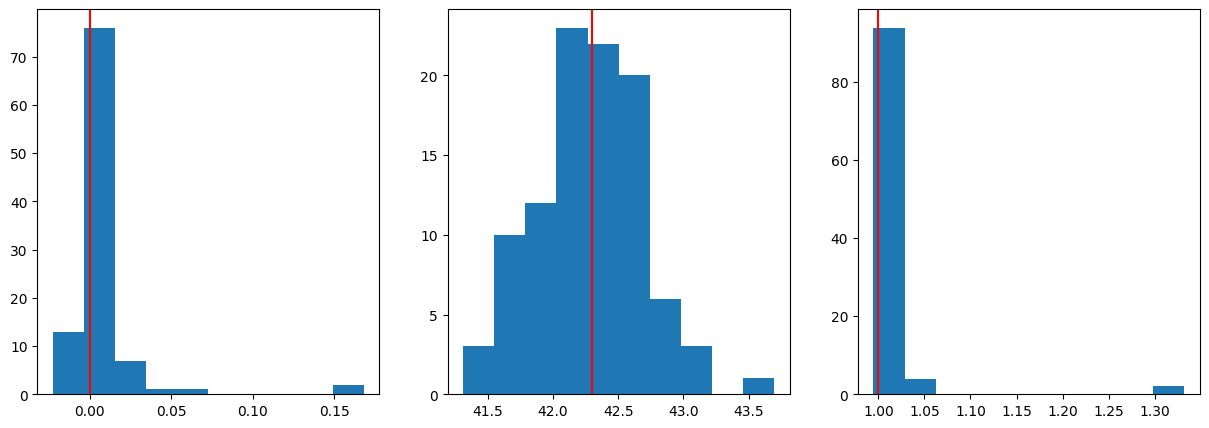

In [40]:
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.hist([p.delta_index.m for p in results])
plt.axvline(results[0].delta_index.nominal_value.m, color='red')

plt.subplot(132)
plt.hist([p.theta23.m for p in results])
plt.axvline(results[0].theta23.nominal_value.m, color='red')

plt.subplot(133)
plt.hist([p.aeff_scale.m for p in results])
plt.axvline(results[0].aeff_scale.nominal_value.m, color='red')